C:\Users\rjwei\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


 Predicted Gesture: jump


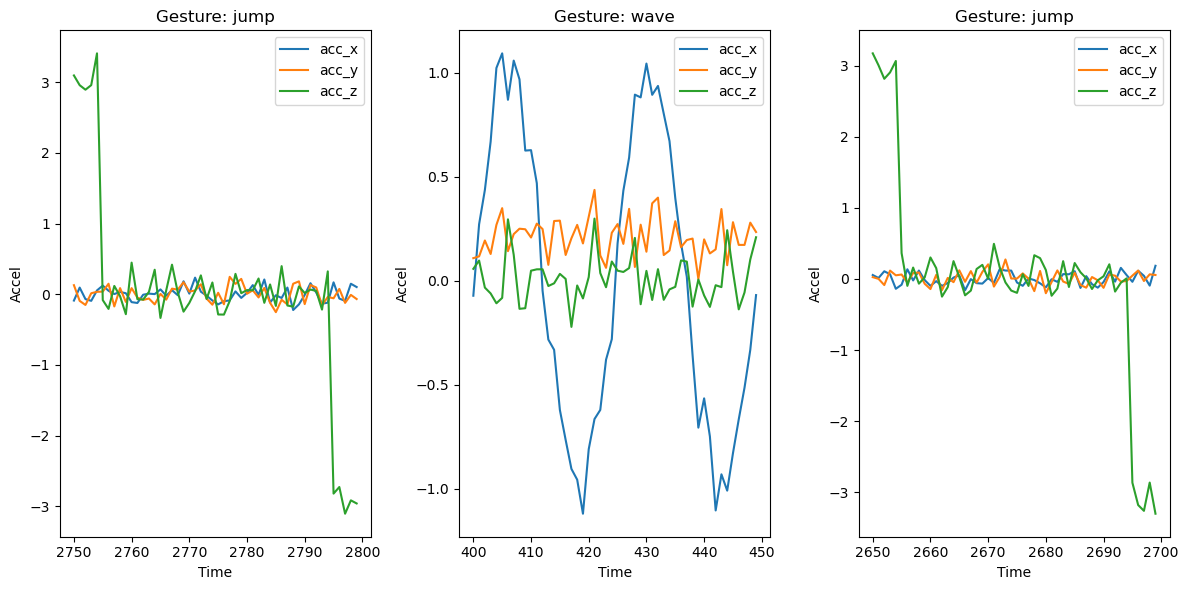

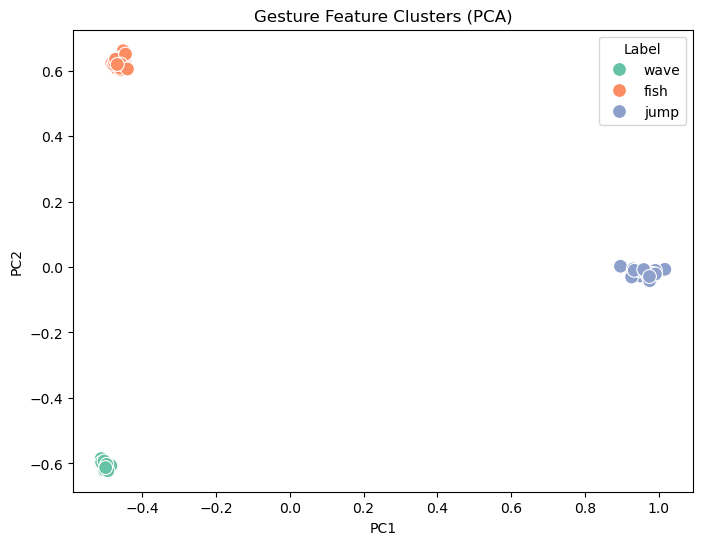

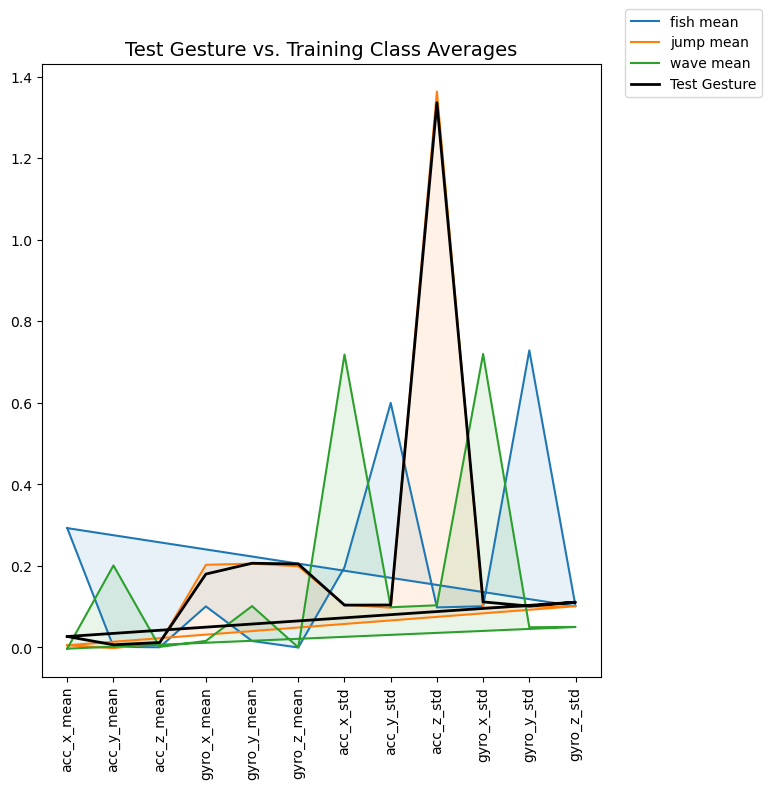

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from math import pi

# === Parameters ===
SAMPLES_PER_GESTURE = 50

# === Load data ===
df_train = pd.read_csv("labeled_gestures.csv")
df_test = pd.read_csv("gesture.csv")

# === Feature extraction ===
def extract_features(df):
    return pd.Series({
        'acc_x_mean': df['acc_x'].mean(),
        'acc_y_mean': df['acc_y'].mean(),
        'acc_z_mean': df['acc_z'].mean(),
        'gyro_x_mean': df['gyro_x'].mean(),
        'gyro_y_mean': df['gyro_y'].mean(),
        'gyro_z_mean': df['gyro_z'].mean(),
        'acc_x_std': df['acc_x'].std(),
        'acc_y_std': df['acc_y'].std(),
        'acc_z_std': df['acc_z'].std(),
        'gyro_x_std': df['gyro_x'].std(),
        'gyro_y_std': df['gyro_y'].std(),
        'gyro_z_std': df['gyro_z'].std(),
    })

# === Split training gestures ===
gesture_chunks = [
    df_train.iloc[i:i+SAMPLES_PER_GESTURE]
    for i in range(0, len(df_train), SAMPLES_PER_GESTURE)
    if len(df_train.iloc[i:i+SAMPLES_PER_GESTURE]) == SAMPLES_PER_GESTURE
]

X_train = []
y_train = []

for chunk in gesture_chunks:
    features = extract_features(chunk)
    label = chunk['label'].iloc[0]
    X_train.append(features)
    y_train.append(label)

X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# === Encode labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

# === Train model ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_encoded)

# === Prepare test sample ===
X_test = extract_features(df_test).values.reshape(1, -1)
predicted_class = clf.predict(X_test)[0]
predicted_label = le.inverse_transform([predicted_class])[0]
print(f" Predicted Gesture: {predicted_label}")

# --------------------------------------------------
# 1. Plot 3 random training gestures
# --------------------------------------------------
sampled = df_train.groupby(df_train.index // SAMPLES_PER_GESTURE).apply(lambda x: x).reset_index(drop=True)
plt.figure(figsize=(12, 6))
for i, gesture_idx in enumerate(np.random.choice(len(gesture_chunks), 3, replace=False)):
    chunk = gesture_chunks[gesture_idx]
    label = chunk['label'].iloc[0]
    plt.subplot(1, 3, i+1)
    plt.plot(chunk[['acc_x', 'acc_y', 'acc_z']])
    plt.title(f"Gesture: {label}")
    plt.xlabel("Time")
    plt.ylabel("Accel")
    plt.legend(['acc_x', 'acc_y', 'acc_z'])
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2. PCA plot of feature space
# --------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='Set2', s=100)
plt.title("Gesture Feature Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label")
plt.show()

# --------------------------------------------------
# 3. Radar chart: test vs class means
# --------------------------------------------------
features_list = X_train.columns.tolist()
test_feat = extract_features(df_test)

# Compute class-wise mean
class_means = X_train.copy()
class_means["label"] = y_train
class_means = class_means.groupby("label").mean()

# Radar plot setup
categories = features_list
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))

# Class means
for label in class_means.index:
    values = class_means.loc[label].values.flatten().tolist()
    values += values[:1]
    plt.plot(angles, values, label=f"{label} mean")
    plt.fill(angles, values, alpha=0.1)

# Test gesture
test_values = test_feat.values.flatten().tolist()
test_values += test_values[:1]
plt.plot(angles, test_values, color='black', linewidth=2, label="Test Gesture")

# Final radar plot formatting
plt.xticks(angles[:-1], categories, rotation=90)
plt.title("Test Gesture vs. Training Class Averages", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()